# CAFEH GTEx paper figures

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

[(array([ 42., 171., 204., 207., 162., 110.,  55.,  30.,  13.,   6.]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
  <a list of 10 Patch objects>),
 (array([ 42., 171., 204., 207., 162., 110.,  55.,  30.,  13.,   6.]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
  <a list of 10 Patch objects>)]

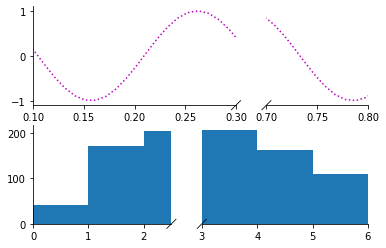

In [2]:
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec
import numpy as np

sps1, sps2 = GridSpec(2,1)

bax = brokenaxes(xlims=((.1, .3), (.7, .8)), subplot_spec=sps1)
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(x*30), ls=':', color='m')

x = np.random.poisson(3, 1000)
bax = brokenaxes(xlims=((0, 2.5), (3, 6)), subplot_spec=sps2)
bax.hist(x, histtype='bar')

In [3]:
def load_model(gene, decompress=True, rel='../'):
    p = gene2path.get(gene)
    m = pickle.load(open(rel + p, 'rb'))
    if decompress:
        m._decompress_model()
    return m

def load_active(gene, rel='../'):
    p = gene2path.get(gene)
    m = pickle.load(open(rel + p, 'rb'))
    df = pd.DataFrame(m.active, index=m.study_ids)
    return df

def load_variant_report(gene, rel='../'):
    p = rel + gene2path.get(gene) + '.variant_report'
    df = pd.read_csv(p, sep='\t')
    return df

In [4]:
def f(x):
    d = {}
    d['pi_sum'] = x['pi'].sum()
    d['z_avg'] = (x['pi'] * x['effect'] / np.sqrt(x['effect_var'])).sum() / x['pi'].sum() * x['p_active'].values[0]
    
    a = (x['effect'] / np.sqrt(x['effect_var']))
    d['z_max'] = a.loc[a.abs().idxmax()] * x['p_active'].values[0]
    d['effect_average'] = (x['pi'] * x['effect']).sum() / x['pi'].sum()
    d['p_active'] = (x['p_active'].values[0])


    return pd.Series(d)

def generate_coloc_table(gene):
    v = load_variant_report(gene)
    m = load_model(gene, decompress=False)

    component_summary = v.groupby(['top_component', 'study']).apply(f).reset_index()
    top_components = component_summary.iloc[
        component_summary.groupby('study').apply(lambda x: x.z_max.abs().idxmax())]
    top_components = top_components.set_index('study')

    # get p_coloc_top
    result = pd.DataFrame(
        columns=['share_top', 'p_coloc_top', 'p_coloc'],
        index=pd.MultiIndex.from_product([top_components.index, top_components.index]))
    result['share_top'] = np.equal.outer(top_components.top_component, top_components.top_component).ravel()
    result['p_coloc_top'] = np.outer(top_components.p_active, top_components.p_active).ravel()

    # add p_coloc
    active = pd.DataFrame(m.active, index=m.study_ids)
    a = active.loc[:, active.max(0) > 0.5].loc[top_components.index].values
    result['p_coloc_any'] = (1 - np.exp(np.sum(np.log(1 - a[None]*a[:, None]), axis=-1))).ravel()

    # add p_coloc_all
    a = active.loc[:, active.max(0) > 0.5].loc[top_components.index].values
    result['p_coloc_all'] = np.exp(np.sum(np.log(a[None]*a[:, None]), axis=-1)).ravel()

    # clean up
    result = result.reset_index().rename(columns={'level_0': 'study1', 'level_1': 'study2'})
    result = result[result.study1 < result.study2]  # filter down to unique comparisons
    result['p_coloc_top'] = result.p_coloc_top * result.share_top  # 0 if they don't share top component

    result['gene'] = gene
    result = result.loc[:, ['gene', 'study1', 'study2', 'p_coloc', 'p_coloc_all', 'p_coloc_top']]
    return result

def generate_coloc_table_marios(gene):
    v = load_variant_report(gene)
    m = load_model(gene, decompress=False)

    component_summary = v.groupby(['top_component', 'study']).apply(f).reset_index()
    top_components = component_summary.iloc[
        component_summary.groupby('study').apply(lambda x: x.z_max.abs().idxmax())]
    top_components = top_components.set_index('study')

    # get p_coloc_top
    result = pd.DataFrame(
        columns=['share_top', 'p_coloc_top', 'p_coloc_any'],
        index=pd.MultiIndex.from_product([top_components.index, top_components.index]))
    result['share_top'] = np.equal.outer(top_components.top_component, top_components.top_component).ravel()
    result['p_coloc_top'] = np.outer(top_components.p_active, top_components.p_active).ravel()

    # add p_coloc
    active = pd.DataFrame(m.active, index=m.study_ids)
    a = active.loc[:, active.max(0) > 0.5].loc[top_components.index].values
    T = a.shape[0]
    result['p_coloc_any'] = np.array([[a[[i, j]].min(0).max() for i in range(T)] for j in range(T)]).ravel() 

    # add p_coloc_all
    result['p_coloc_all'] = np.array([[a[[i, j]].min() for i in range(T)] for j in range(T)]).ravel()

    # clean up
    result = result.reset_index().rename(columns={'level_0': 'study1', 'level_1': 'study2'})
    result = result[result.study1 < result.study2]  # filter down to unique comparisons
    result['p_coloc_top'] = result.p_coloc_top * result.share_top  # 0 if they don't share top component

    result['gene'] = gene
    result = result.loc[:, ['gene', 'study1', 'study2', 'p_coloc_any', 'p_coloc_all', 'p_coloc_top']]
    return result

In [50]:
def generate_coloc_table_marios(gene):
    v = load_variant_report(gene)
    m = load_model(gene, decompress=False)

    component_summary = v.groupby(['top_component', 'study']).apply(f).reset_index()
    top_components = component_summary.iloc[
        component_summary.groupby('study').apply(lambda x: x.z_max.abs().idxmax())]
    top_components = top_components.set_index('study')

    top_components = top_components.loc[m.study_ids]
    top_components.p_active = top_components.p_active.fillna(0)

    # get p_coloc_top
    result = pd.DataFrame(
        columns=['share_top', 'p_coloc_top', 'p_coloc_any'],
        index=pd.MultiIndex.from_product([top_components.index, top_components.index]))
    result['share_top'] = np.equal.outer(top_components.top_component, top_components.top_component).ravel()
    result['p_coloc_top'] = np.outer(top_components.p_active, top_components.p_active).ravel()

    # add p_coloc
    active = pd.DataFrame(m.active, index=m.study_ids)
    a = active.loc[:, active.max(0) > 0.5].loc[top_components.index].values
    T = a.shape[0]
    result['p_coloc_any'] = np.array([[a[[i, j]].min(0).max() for i in range(T)] for j in range(T)]).ravel() 

    # add p_coloc_all
    result['p_coloc_all'] = np.array([[a[[i, j]].min() for i in range(T)] for j in range(T)]).ravel()

    # clean up
    result = result.reset_index().rename(columns={'level_0': 'study1', 'level_1': 'study2'})
    result = result[result.study1 < result.study2]  # filter down to unique comparisons
    result['p_coloc_top'] = result.p_coloc_top * result.share_top  # 0 if they don't share top component

    result['gene'] = gene
    result = result.loc[:, ['gene', 'study1', 'study2', 'p_coloc_any', 'p_coloc_all', 'p_coloc_top']]
    return result

In [25]:
model_paths = np.loadtxt('../output/requests/GTEx_cafeh_genotype_ss.txt', dtype=str)
vr_paths = np.loadtxt('../output/requests/GTEx_cafeh_genotype_ss_variant_reports.txt', dtype=str)
gene2path = {p.split('/')[3]: p for p in model_paths} 

In [51]:
generate_coloc_table_marios(gene)

/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.


,gene,study1,study2,p_coloc_any,p_coloc_all,p_coloc_top
8,ENSG00000187634.11,Nerve_Tibial,Pancreas,0.145275,0.092555,0.0
15,ENSG00000187634.11,Nerve_Tibial,Prostate,0.120686,0.094325,0.0
16,ENSG00000187634.11,Nerve_Tibial,Vagina,0.152220,0.094325,0.0
17,ENSG00000187634.11,Nerve_Tibial,Testis,0.683355,0.094325,0.0
24,ENSG00000187634.11,Nerve_Tibial,Spleen,0.145275,0.094325,0.0
...,...,...,...,...,...,...
2298,ENSG00000187634.11,Brain_Cortex,Esophagus_Mucosa,0.100207,0.092267,0.0
2299,ENSG00000187634.11,Brain_Cortex,Small_Intestine_Terminal_Ileum,0.098090,0.094832,0.0
2300,ENSG00000187634.11,Brain_Cortex,Uterus,0.098073,0.092809,0.0
2301,ENSG00000187634.11,Brain_Cortex,Ovary,0.120967,0.095922,0.0


In [46]:
top_components = top_components.loc[active.index]
top_components.p_active = top_components.p_active.fillna(0)

In [43]:
top_components = top_components.loc[active.index]
top_components.p_active

,top_component,pi_sum,z_avg,z_max,effect_average,p_active
Nerve_Tibial,7.0,1.000000,5.847655,5.847655,0.174508,0.999998
Brain_Cerebellum,7.0,1.000000,5.272132,5.272132,0.274294,0.999956
Kidney_Cortex,NaN,NaN,NaN,NaN,NaN,NaN
Brain_Putamen_basal_ganglia,10.0,1.000000,5.413678,5.413681,1.334625,0.999979
Brain_Substantia_nigra,7.0,1.000000,4.754150,4.754150,0.428030,0.999466
Brain_Frontal_Cortex_BA9,9.0,0.999010,1.253604,1.699042,0.329182,0.614773
Breast_Mammary_Tissue,NaN,NaN,NaN,NaN,NaN,NaN
Brain_Hypothalamus,NaN,NaN,NaN,NaN,NaN,NaN
Pancreas,NaN,NaN,NaN,NaN,NaN,NaN
Lung,7.0,1.000000,1.454448,1.454448,0.059423,0.553812


In [32]:
p_coloc_top

array([0.22769231, 0.22756707, 0.82575758, ..., 0.3707483 , 0.18647343,
       0.66326531])

### Tissue pair histograms

In [6]:
import os

In [7]:
if not os.path.isfile('p_coloc.pkl'):
    p_coloc = []
    for gene in tqdm(list(gene2path.keys())):
        try:
            d = generate_coloc_table(gene)
            p_coloc.append(d)
        except Exception as e:
            print(gene)
    pickle.dump(p_coloc, open('p_coloc.pkl', 'wb'))

p_coloc = pickle.load(open('p_coloc.pkl', 'rb'))

In [7]:
if not os.path.isfile('p_coloc_marios.pkl'):
    p_coloc = []
    for gene in tqdm(list(gene2path.keys())):
        try:
            d = generate_coloc_table_marios(gene)
            p_coloc.append(d)
        except Exception as e:
            print(gene)
    pickle.dump(p_coloc, open('p_coloc_marios.pkl', 'wb'))

p_coloc = pickle.load(open('p_coloc_marios.pkl', 'rb'))

In [17]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
a = np.array([[2, 0, 0], [1, 0.5, 3]])
b = np.array([[0, 3, 1], [1, 2, 0]])
c = np.array([[3, 2, 1], [2, 1, 3]])

### Plots with paper definition of p_coloc_any, p_coloc_top, p_coloc_all

In [19]:
thresh = 0.5
p_coloc_any = np.array([(p.p_coloc_any > thresh).mean() for p in p_coloc])
p_coloc_top = np.array([(p.p_coloc_top > thresh).mean() for p in p_coloc])
p_coloc_all = np.array([(p.p_coloc_all > thresh).mean() for p in p_coloc])

/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


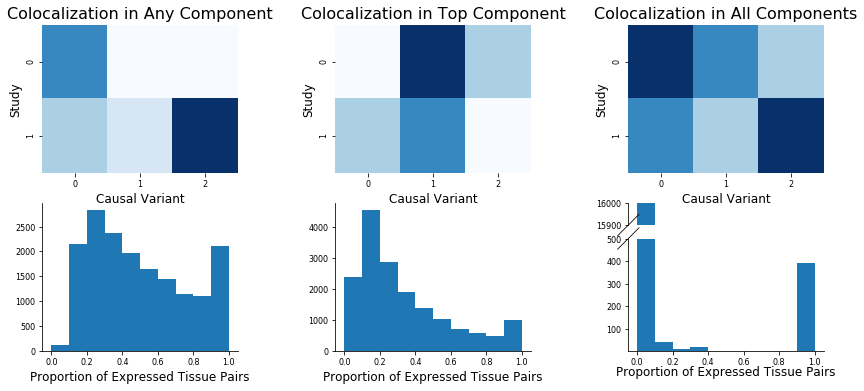

In [22]:
fig11 = plt.figure(figsize=(14, 6), constrained_layout=False)
gs = fig11.add_gridspec(2,3, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs[0, 0])
sns.heatmap(a, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Any Component')

ax = plt.subplot(gs[0, 1])
sns.heatmap(b, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Top Component')

ax = plt.subplot(gs[0, 2])
sns.heatmap(c, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in All Components')

ax = plt.subplot(gs[1, 0])
ax.hist(p_coloc_any[p_coloc_any >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

ax = plt.subplot(gs[1, 1])
ax.hist(p_coloc_top[p_coloc_top >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

bax = brokenaxes(ylims=((1, 500), (15900, 16000)), subplot_spec=gs[1, 2])
bax.hist(p_coloc_all[p_coloc_all >= 0])
bax.set_xlabel('Proportion of Expressed Tissue Pairs')
plt.tight_layout()

/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


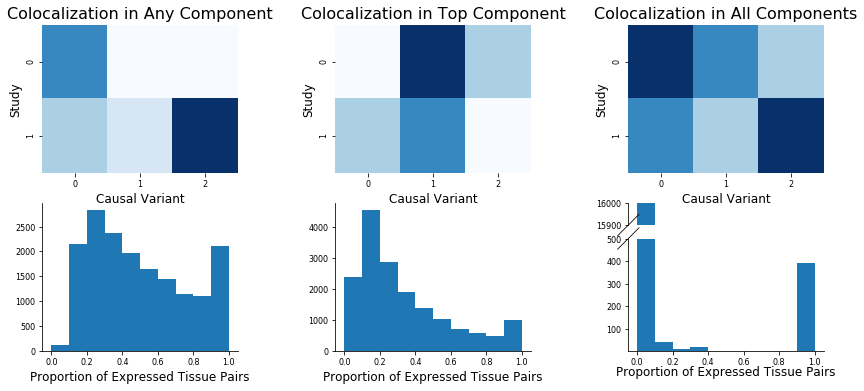

In [12]:
fig11 = plt.figure(figsize=(14, 6), constrained_layout=False)
gs = fig11.add_gridspec(2,3, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs[0, 0])
sns.heatmap(a, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Any Component')

ax = plt.subplot(gs[0, 1])
sns.heatmap(b, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Top Component')

ax = plt.subplot(gs[0, 2])
sns.heatmap(c, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in All Components')

ax = plt.subplot(gs[1, 0])
ax.hist(p_coloc_any[p_coloc_any >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

ax = plt.subplot(gs[1, 1])
ax.hist(p_coloc_top[p_coloc_top >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

bax = brokenaxes(ylims=((1, 500), (15900, 16000)), subplot_spec=gs[1, 2])
bax.hist(p_coloc_all[p_coloc_all >= 0])
bax.set_xlabel('Proportion of Expressed Tissue Pairs')
plt.tight_layout()

In [13]:
egenes = pd.read_csv('../output/GTEx/egenes.txt', sep='\t')
gene2eqtl_tissues = egenes.groupby('gene_id').tissue.unique().to_dict()

In [ ]:
for p in p_coloc

In [23]:
p_coloc_eqtl = []
for p in tqdm(p_coloc):
    try:
        gene = p.iloc[0].gene
        tissues = gene2eqtl_tissues.get(gene)
        p_coloc_eqtl.append(p[p.study1.isin(tissues) & p.study2.isin(tissues)])
    except Exception as e:
        print(gene, e)


  1%|          | 156/17216 [00:00<00:33, 510.72it/s]

ENSG00000078900.14 single positional indexer is out-of-bounds
ENSG00000131686.14 single positional indexer is out-of-bounds
ENSG00000162496.8 single positional indexer is out-of-bounds
ENSG00000157330.9 single positional indexer is out-of-bounds
ENSG00000157330.9 single positional indexer is out-of-bounds
ENSG00000157330.9 single positional indexer is out-of-bounds
ENSG00000157330.9 single positional indexer is out-of-bounds
ENSG00000157330.9 single positional indexer is out-of-bounds



  2%|▏         | 313/17216 [00:00<00:32, 515.18it/s]

ENSG00000162542.13 single positional indexer is out-of-bounds
ENSG00000133216.16 single positional indexer is out-of-bounds
ENSG00000133216.16 single positional indexer is out-of-bounds



  3%|▎         | 517/17216 [00:01<00:32, 507.58it/s]

ENSG00000121904.17 single positional indexer is out-of-bounds
ENSG00000065978.18 single positional indexer is out-of-bounds



  4%|▍         | 773/17216 [00:01<00:32, 508.19it/s]

ENSG00000116641.17 single positional indexer is out-of-bounds



  6%|▌         | 978/17216 [00:01<00:31, 507.84it/s]

ENSG00000143125.5 single positional indexer is out-of-bounds
ENSG00000175984.14 single positional indexer is out-of-bounds



  7%|▋         | 1185/17216 [00:02<00:31, 512.45it/s]

ENSG00000185962.1 single positional indexer is out-of-bounds
ENSG00000197084.5 single positional indexer is out-of-bounds
ENSG00000163207.6 single positional indexer is out-of-bounds



  8%|▊         | 1442/17216 [00:02<00:30, 509.15it/s]

ENSG00000158869.10 single positional indexer is out-of-bounds
ENSG00000116132.11 single positional indexer is out-of-bounds



  9%|▉         | 1544/17216 [00:03<00:30, 507.99it/s]

ENSG00000143344.15 single positional indexer is out-of-bounds
ENSG00000134365.12 single positional indexer is out-of-bounds



 10%|▉         | 1701/17216 [00:03<00:30, 509.57it/s]

ENSG00000263961.6 single positional indexer is out-of-bounds
ENSG00000136634.5 single positional indexer is out-of-bounds
ENSG00000136634.5 single positional indexer is out-of-bounds



 10%|█         | 1803/17216 [00:03<00:30, 504.81it/s]

ENSG00000143816.7 single positional indexer is out-of-bounds



 11%|█         | 1910/17216 [00:03<00:29, 517.72it/s]

ENSG00000169224.12 single positional indexer is out-of-bounds
ENSG00000169224.12 single positional indexer is out-of-bounds
ENSG00000169224.12 single positional indexer is out-of-bounds
ENSG00000169224.12 single positional indexer is out-of-bounds
ENSG00000169224.12 single positional indexer is out-of-bounds
ENSG00000196539.3 single positional indexer is out-of-bounds
ENSG00000196539.3 single positional indexer is out-of-bounds
ENSG00000171163.15 single positional indexer is out-of-bounds
ENSG00000084674.14 single positional indexer is out-of-bounds



 12%|█▏        | 2066/17216 [00:04<00:29, 512.17it/s]

ENSG00000138073.13 single positional indexer is out-of-bounds
ENSG00000055332.16 single positional indexer is out-of-bounds
ENSG00000115904.12 single positional indexer is out-of-bounds



 13%|█▎        | 2170/17216 [00:04<00:29, 508.47it/s]

ENSG00000116016.13 single positional indexer is out-of-bounds



 13%|█▎        | 2324/17216 [00:04<00:29, 502.49it/s]

ENSG00000116096.5 single positional indexer is out-of-bounds
ENSG00000144115.16 single positional indexer is out-of-bounds



 14%|█▍        | 2478/17216 [00:04<00:29, 504.32it/s]

ENSG00000144057.15 single positional indexer is out-of-bounds
ENSG00000136688.10 single positional indexer is out-of-bounds
ENSG00000136732.14 single positional indexer is out-of-bounds
ENSG00000222014.5 single positional indexer is out-of-bounds
ENSG00000152093.7 single positional indexer is out-of-bounds



 15%|█▍        | 2580/17216 [00:05<00:29, 503.01it/s]

ENSG00000082258.12 single positional indexer is out-of-bounds



 17%|█▋        | 2992/17216 [00:05<00:27, 515.66it/s]

ENSG00000173744.17 single positional indexer is out-of-bounds
ENSG00000066248.14 single positional indexer is out-of-bounds
ENSG00000085982.13 single positional indexer is out-of-bounds
ENSG00000242515.5 single positional indexer is out-of-bounds
ENSG00000167165.18 single positional indexer is out-of-bounds
ENSG00000167165.18 single positional indexer is out-of-bounds



 19%|█▉        | 3300/17216 [00:06<00:27, 505.18it/s]

ENSG00000168329.13 single positional indexer is out-of-bounds



 20%|██        | 3455/17216 [00:06<00:27, 503.53it/s]

ENSG00000164082.14 single positional indexer is out-of-bounds
ENSG00000164082.14 single positional indexer is out-of-bounds
ENSG00000114405.10 single positional indexer is out-of-bounds
ENSG00000163630.10 single positional indexer is out-of-bounds



 21%|██▏       | 3663/17216 [00:07<00:26, 509.45it/s]

ENSG00000114487.9 single positional indexer is out-of-bounds
ENSG00000091972.18 single positional indexer is out-of-bounds
ENSG00000144847.12 single positional indexer is out-of-bounds



 22%|██▏       | 3767/17216 [00:07<00:26, 511.07it/s]

ENSG00000180767.9 single positional indexer is out-of-bounds
ENSG00000132394.10 single positional indexer is out-of-bounds
ENSG00000251287.8 single positional indexer is out-of-bounds
ENSG00000175110.11 single positional indexer is out-of-bounds
ENSG00000158258.16 single positional indexer is out-of-bounds



 23%|██▎       | 3924/17216 [00:07<00:25, 514.05it/s]

ENSG00000196542.8 single positional indexer is out-of-bounds
ENSG00000075651.15 single positional indexer is out-of-bounds
ENSG00000114346.13 single positional indexer is out-of-bounds
ENSG00000114770.16 single positional indexer is out-of-bounds



 23%|██▎       | 4028/17216 [00:07<00:25, 511.59it/s]


ENSG00000157005.3 single positional indexer is out-of-bounds


 25%|██▍       | 4285/17216 [00:08<00:25, 505.50it/s]

ENSG00000124406.16 single positional indexer is out-of-bounds
ENSG00000151834.15 single positional indexer is out-of-bounds



 26%|██▌       | 4440/17216 [00:08<00:25, 509.72it/s]

ENSG00000156269.4 single positional indexer is out-of-bounds
ENSG00000182168.14 single positional indexer is out-of-bounds



 27%|██▋       | 4647/17216 [00:09<00:24, 512.24it/s]

ENSG00000153132.12 single positional indexer is out-of-bounds
ENSG00000197465.13 single positional indexer is out-of-bounds
ENSG00000109686.17 single positional indexer is out-of-bounds
ENSG00000109466.13 single positional indexer is out-of-bounds



 28%|██▊       | 4803/17216 [00:09<00:24, 510.86it/s]

ENSG00000205097.6 single positional indexer is out-of-bounds
ENSG00000112902.11 single positional indexer is out-of-bounds
ENSG00000151388.10 single positional indexer is out-of-bounds



 29%|██▉       | 4960/17216 [00:09<00:24, 509.14it/s]

ENSG00000145649.7 single positional indexer is out-of-bounds
ENSG00000062194.15 single positional indexer is out-of-bounds



 30%|███       | 5165/17216 [00:10<00:23, 506.58it/s]

ENSG00000164902.13 single positional indexer is out-of-bounds
ENSG00000145832.12 single positional indexer is out-of-bounds
ENSG00000271824.1 single positional indexer is out-of-bounds



 32%|███▏      | 5473/17216 [00:10<00:23, 507.25it/s]

ENSG00000113263.12 single positional indexer is out-of-bounds



 59%|█████▉    | 10239/17216 [00:40<00:14, 477.27it/s][A

ENSG00000165810.16 single positional indexer is out-of-bounds
ENSG00000165810.16 single positional indexer is out-of-bounds
ENSG00000146038.11 single positional indexer is out-of-bounds



 33%|███▎      | 5732/17216 [00:11<00:22, 515.02it/s]

ENSG00000079689.13 single positional indexer is out-of-bounds
ENSG00000124564.17 single positional indexer is out-of-bounds
ENSG00000197903.7 single positional indexer is out-of-bounds
ENSG00000233822.4 single positional indexer is out-of-bounds
ENSG00000233822.4 single positional indexer is out-of-bounds
ENSG00000197935.6 single positional indexer is out-of-bounds
ENSG00000204544.5 single positional indexer is out-of-bounds



 35%|███▌      | 6094/17216 [00:12<00:21, 511.04it/s]

ENSG00000146070.16 single positional indexer is out-of-bounds
ENSG00000096006.11 single positional indexer is out-of-bounds
ENSG00000170927.14 single positional indexer is out-of-bounds
ENSG00000118482.11 single positional indexer is out-of-bounds



 37%|███▋      | 6301/17216 [00:12<00:21, 508.94it/s]

ENSG00000112769.18 single positional indexer is out-of-bounds
ENSG00000154269.14 single positional indexer is out-of-bounds



 38%|███▊      | 6557/17216 [00:12<00:20, 507.64it/s]

ENSG00000177706.8 single positional indexer is out-of-bounds
ENSG00000003147.17 single positional indexer is out-of-bounds
ENSG00000071189.21 single positional indexer is out-of-bounds



 39%|███▊      | 6663/17216 [00:13<00:20, 511.18it/s]

ENSG00000004846.16 single positional indexer is out-of-bounds
ENSG00000196335.12 single positional indexer is out-of-bounds
ENSG00000253293.4 single positional indexer is out-of-bounds



 40%|███▉      | 6820/17216 [00:13<00:20, 509.65it/s]

ENSG00000106078.17 single positional indexer is out-of-bounds
ENSG00000185290.3 single positional indexer is out-of-bounds
ENSG00000214652.5 single positional indexer is out-of-bounds
ENSG00000165171.10 single positional indexer is out-of-bounds



 41%|████▏     | 7128/17216 [00:14<00:19, 505.21it/s]

ENSG00000091136.13 single positional indexer is out-of-bounds
ENSG00000235631.1 single positional indexer is out-of-bounds



 42%|████▏     | 7230/17216 [00:14<00:24, 404.95it/s]

ENSG00000257335.8 single positional indexer is out-of-bounds
ENSG00000198420.9 single positional indexer is out-of-bounds
ENSG00000198420.9 single positional indexer is out-of-bounds
ENSG00000213214.4 single positional indexer is out-of-bounds



 43%|████▎     | 7378/17216 [00:14<00:23, 422.01it/s]

ENSG00000164816.7 single positional indexer is out-of-bounds
ENSG00000164816.7 single positional indexer is out-of-bounds
ENSG00000205882.8 single positional indexer is out-of-bounds
ENSG00000134028.14 single positional indexer is out-of-bounds



 44%|████▍     | 7533/17216 [00:14<00:20, 478.69it/s]

ENSG00000169154.5 single positional indexer is out-of-bounds
ENSG00000197140.14 single positional indexer is out-of-bounds



 45%|████▍     | 7688/17216 [00:15<00:19, 500.37it/s]

ENSG00000178460.17 single positional indexer is out-of-bounds
ENSG00000147614.3 single positional indexer is out-of-bounds



 46%|████▌     | 7843/17216 [00:15<00:18, 507.99it/s]

ENSG00000147642.16 single positional indexer is out-of-bounds
ENSG00000132294.14 single positional indexer is out-of-bounds
ENSG00000167656.4 single positional indexer is out-of-bounds



 46%|████▋     | 7999/17216 [00:15<00:18, 508.10it/s]

ENSG00000107104.18 single positional indexer is out-of-bounds
ENSG00000096968.13 single positional indexer is out-of-bounds
ENSG00000137033.11 single positional indexer is out-of-bounds
ENSG00000137080.4 single positional indexer is out-of-bounds



 47%|████▋     | 8103/17216 [00:16<00:17, 513.23it/s]

ENSG00000205108.5 single positional indexer is out-of-bounds
ENSG00000154529.14 single positional indexer is out-of-bounds
ENSG00000154529.14 single positional indexer is out-of-bounds
ENSG00000172014.12 single positional indexer is out-of-bounds
ENSG00000274349.4 single positional indexer is out-of-bounds
ENSG00000187866.8 single positional indexer is out-of-bounds



 48%|████▊     | 8259/17216 [00:16<00:17, 511.73it/s]

ENSG00000135047.14 single positional indexer is out-of-bounds
ENSG00000175787.16 single positional indexer is out-of-bounds
ENSG00000198785.4 single positional indexer is out-of-bounds
ENSG00000198785.4 single positional indexer is out-of-bounds
ENSG00000136824.18 single positional indexer is out-of-bounds
ENSG00000136824.18 single positional indexer is out-of-bounds



 49%|████▊     | 8367/17216 [00:16<00:17, 518.96it/s]

ENSG00000136826.14 single positional indexer is out-of-bounds
ENSG00000136826.14 single positional indexer is out-of-bounds
ENSG00000136810.12 single positional indexer is out-of-bounds
ENSG00000157693.14 single positional indexer is out-of-bounds
ENSG00000136834.3 single positional indexer is out-of-bounds



 50%|████▉     | 8575/17216 [00:17<00:17, 506.75it/s]

ENSG00000130717.12 single positional indexer is out-of-bounds



 50%|█████     | 8678/17216 [00:17<00:16, 508.52it/s]

ENSG00000107937.18 single positional indexer is out-of-bounds
ENSG00000196139.13 single positional indexer is out-of-bounds
ENSG00000196139.13 single positional indexer is out-of-bounds



 51%|█████▏    | 8832/17216 [00:17<00:16, 506.38it/s]

ENSG00000095739.10 single positional indexer is out-of-bounds
ENSG00000107968.9 single positional indexer is out-of-bounds



 52%|█████▏    | 9037/17216 [00:17<00:16, 505.55it/s]

ENSG00000204033.9 single positional indexer is out-of-bounds



 54%|█████▍    | 9294/17216 [00:18<00:15, 508.30it/s]

ENSG00000151892.14 single positional indexer is out-of-bounds
ENSG00000187908.16 single positional indexer is out-of-bounds
ENSG00000196177.12 single positional indexer is out-of-bounds



 55%|█████▍    | 9397/17216 [00:18<00:15, 505.66it/s]

ENSG00000177951.17 single positional indexer is out-of-bounds
ENSG00000021762.19 single positional indexer is out-of-bounds
ENSG00000167332.7 single positional indexer is out-of-bounds



 55%|█████▌    | 9502/17216 [00:18<00:15, 510.33it/s]

ENSG00000181074.3 single positional indexer is out-of-bounds
ENSG00000181074.3 single positional indexer is out-of-bounds
ENSG00000180988.2 single positional indexer is out-of-bounds



 56%|█████▌    | 9606/17216 [00:19<00:14, 510.15it/s]

ENSG00000185238.12 single positional indexer is out-of-bounds
ENSG00000149100.12 single positional indexer is out-of-bounds



 56%|█████▋    | 9715/17216 [00:19<00:14, 526.19it/s]

ENSG00000086205.16 single positional indexer is out-of-bounds
ENSG00000086205.16 single positional indexer is out-of-bounds
ENSG00000198561.13 single positional indexer is out-of-bounds
ENSG00000242689.2 single positional indexer is out-of-bounds
ENSG00000197629.5 single positional indexer is out-of-bounds
ENSG00000166902.4 single positional indexer is out-of-bounds
ENSG00000134827.7 single positional indexer is out-of-bounds
ENSG00000166928.10 single positional indexer is out-of-bounds
ENSG00000166959.7 single positional indexer is out-of-bounds



 57%|█████▋    | 9872/17216 [00:19<00:14, 512.63it/s]

ENSG00000162302.12 single positional indexer is out-of-bounds
ENSG00000173621.8 single positional indexer is out-of-bounds



 58%|█████▊    | 10028/17216 [00:19<00:14, 508.36it/s]

ENSG00000162344.3 single positional indexer is out-of-bounds



 59%|█████▉    | 10134/17216 [00:20<00:13, 518.58it/s]

ENSG00000137501.17 single positional indexer is out-of-bounds
ENSG00000086991.12 single positional indexer is out-of-bounds
ENSG00000086991.12 single positional indexer is out-of-bounds
ENSG00000086991.12 single positional indexer is out-of-bounds
ENSG00000165323.15 single positional indexer is out-of-bounds
ENSG00000168876.8 single positional indexer is out-of-bounds
ENSG00000137673.8 single positional indexer is out-of-bounds



 60%|██████    | 10339/17216 [00:20<00:14, 490.14it/s]

ENSG00000166261.10 single positional indexer is out-of-bounds
ENSG00000110002.15 single positional indexer is out-of-bounds
ENSG00000255298.2 single positional indexer is out-of-bounds
ENSG00000196844.8 single positional indexer is out-of-bounds



 61%|██████▏   | 10579/17216 [00:21<00:14, 462.62it/s]

ENSG00000178878.12 single positional indexer is out-of-bounds



 62%|██████▏   | 10719/17216 [00:21<00:14, 455.10it/s]

ENSG00000197376.2 single positional indexer is out-of-bounds
ENSG00000129315.10 single positional indexer is out-of-bounds
ENSG00000123268.8 single positional indexer is out-of-bounds



 63%|██████▎   | 10861/17216 [00:21<00:13, 463.10it/s]

ENSG00000172819.16 single positional indexer is out-of-bounds
ENSG00000185591.9 single positional indexer is out-of-bounds
ENSG00000135426.15 single positional indexer is out-of-bounds



 64%|██████▍   | 11093/17216 [00:22<00:13, 457.64it/s]

ENSG00000205057.4 single positional indexer is out-of-bounds



 66%|██████▌   | 11369/17216 [00:22<00:12, 455.12it/s]

ENSG00000090612.20 single positional indexer is out-of-bounds



 67%|██████▋   | 11601/17216 [00:23<00:12, 460.09it/s]

ENSG00000178695.5 single positional indexer is out-of-bounds
ENSG00000134899.18 single positional indexer is out-of-bounds



 68%|██████▊   | 11704/17216 [00:23<00:11, 474.56it/s]

ENSG00000198824.5 single positional indexer is out-of-bounds
ENSG00000187537.13 single positional indexer is out-of-bounds
ENSG00000187537.13 single positional indexer is out-of-bounds
ENSG00000187537.13 single positional indexer is out-of-bounds
ENSG00000187537.13 single positional indexer is out-of-bounds
ENSG00000198805.11 single positional indexer is out-of-bounds
ENSG00000198805.11 single positional indexer is out-of-bounds
ENSG00000214274.9 single positional indexer is out-of-bounds
ENSG00000165795.23 single positional indexer is out-of-bounds
ENSG00000165804.15 single positional indexer is out-of-bounds
ENSG00000165804.15 single positional indexer is out-of-bounds
ENSG00000100804.18 single positional indexer is out-of-bounds



 69%|██████▉   | 11846/17216 [00:23<00:11, 462.06it/s]

ENSG00000165379.13 single positional indexer is out-of-bounds
ENSG00000139977.13 single positional indexer is out-of-bounds
ENSG00000179008.8 single positional indexer is out-of-bounds



 71%|███████▏  | 12269/17216 [00:24<00:10, 465.85it/s]

ENSG00000184986.10 single positional indexer is out-of-bounds
ENSG00000184986.10 single positional indexer is out-of-bounds
ENSG00000184986.10 single positional indexer is out-of-bounds
ENSG00000261739.2 single positional indexer is out-of-bounds
ENSG00000104067.16 single positional indexer is out-of-bounds
ENSG00000172575.11 single positional indexer is out-of-bounds



 73%|███████▎  | 12598/17216 [00:25<00:09, 464.02it/s]

ENSG00000205363.5 single positional indexer is out-of-bounds
ENSG00000140464.19 single positional indexer is out-of-bounds
ENSG00000137868.18 single positional indexer is out-of-bounds
ENSG00000167173.18 single positional indexer is out-of-bounds
ENSG00000167173.18 single positional indexer is out-of-bounds



 75%|███████▌  | 12923/17216 [00:26<00:09, 455.39it/s]

ENSG00000008517.16 single positional indexer is out-of-bounds



 76%|███████▌  | 13062/17216 [00:26<00:09, 454.67it/s]

ENSG00000169347.16 single positional indexer is out-of-bounds
ENSG00000213648.10 single positional indexer is out-of-bounds



 77%|███████▋  | 13342/17216 [00:27<00:08, 461.92it/s]

ENSG00000125166.12 single positional indexer is out-of-bounds
ENSG00000159593.14 single positional indexer is out-of-bounds



 79%|███████▉  | 13573/17216 [00:27<00:08, 451.60it/s]

ENSG00000141013.16 single positional indexer is out-of-bounds



 80%|███████▉  | 13713/17216 [00:27<00:07, 457.13it/s]

ENSG00000179314.13 single positional indexer is out-of-bounds
ENSG00000169992.9 single positional indexer is out-of-bounds
ENSG00000169992.9 single positional indexer is out-of-bounds



 80%|████████  | 13852/17216 [00:28<00:07, 459.39it/s]

ENSG00000213077.5 single positional indexer is out-of-bounds
ENSG00000244045.12 single positional indexer is out-of-bounds



 82%|████████▏ | 14045/17216 [00:28<00:06, 477.48it/s]

ENSG00000276070.4 single positional indexer is out-of-bounds
ENSG00000276070.4 single positional indexer is out-of-bounds
ENSG00000278053.4 single positional indexer is out-of-bounds
ENSG00000274419.6 single positional indexer is out-of-bounds
ENSG00000273559.4 single positional indexer is out-of-bounds
ENSG00000167258.13 single positional indexer is out-of-bounds
ENSG00000188581.8 single positional indexer is out-of-bounds
ENSG00000188581.8 single positional indexer is out-of-bounds
ENSG00000188581.8 single positional indexer is out-of-bounds
ENSG00000188581.8 single positional indexer is out-of-bounds
ENSG00000108759.3 single positional indexer is out-of-bounds



 82%|████████▏ | 14141/17216 [00:28<00:06, 471.74it/s]

ENSG00000173812.10 single positional indexer is out-of-bounds
ENSG00000131471.6 single positional indexer is out-of-bounds



 83%|████████▎ | 14283/17216 [00:29<00:06, 463.70it/s]

ENSG00000141293.15 single positional indexer is out-of-bounds
ENSG00000108960.7 single positional indexer is out-of-bounds
ENSG00000108375.12 single positional indexer is out-of-bounds



 84%|████████▎ | 14377/17216 [00:29<00:06, 461.16it/s]

ENSG00000121101.15 single positional indexer is out-of-bounds
ENSG00000213218.10 single positional indexer is out-of-bounds
ENSG00000075461.5 single positional indexer is out-of-bounds



 84%|████████▍ | 14470/17216 [00:29<00:06, 454.14it/s]

ENSG00000182040.8 single positional indexer is out-of-bounds



 85%|████████▌ | 14703/17216 [00:30<00:05, 458.38it/s]

ENSG00000154864.11 single positional indexer is out-of-bounds
ENSG00000176136.6 single positional indexer is out-of-bounds
ENSG00000175322.11 single positional indexer is out-of-bounds
ENSG00000134760.5 single positional indexer is out-of-bounds



 86%|████████▋ | 14888/17216 [00:30<00:05, 454.28it/s]

ENSG00000179981.9 single positional indexer is out-of-bounds



 88%|████████▊ | 15073/17216 [00:30<00:04, 453.01it/s]

ENSG00000196365.11 single positional indexer is out-of-bounds
ENSG00000188000.3 single positional indexer is out-of-bounds



 88%|████████▊ | 15165/17216 [00:31<00:04, 455.44it/s]

ENSG00000080573.6 single positional indexer is out-of-bounds



 89%|████████▉ | 15305/17216 [00:31<00:04, 458.98it/s]

ENSG00000105143.12 single positional indexer is out-of-bounds
ENSG00000171954.12 single positional indexer is out-of-bounds
ENSG00000196684.12 single positional indexer is out-of-bounds



 90%|████████▉ | 15443/17216 [00:31<00:03, 453.69it/s]

ENSG00000196109.6 single positional indexer is out-of-bounds
ENSG00000089327.14 single positional indexer is out-of-bounds



 91%|█████████ | 15676/17216 [00:32<00:03, 462.64it/s]

ENSG00000170956.16 single positional indexer is out-of-bounds
ENSG00000079385.21 single positional indexer is out-of-bounds
ENSG00000221878.12 single positional indexer is out-of-bounds



 92%|█████████▏| 15864/17216 [00:32<00:02, 457.70it/s]

ENSG00000178980.14 single positional indexer is out-of-bounds
ENSG00000105398.3 single positional indexer is out-of-bounds
ENSG00000161558.10 single positional indexer is out-of-bounds



 93%|█████████▎| 16003/17216 [00:32<00:02, 456.71it/s]

ENSG00000105383.14 single positional indexer is out-of-bounds
ENSG00000105366.15 single positional indexer is out-of-bounds
ENSG00000197928.10 single positional indexer is out-of-bounds



 94%|█████████▎| 16097/17216 [00:33<00:02, 460.12it/s]

ENSG00000063241.7 single positional indexer is out-of-bounds
ENSG00000198300.12 single positional indexer is out-of-bounds



 95%|█████████▍| 16283/17216 [00:33<00:02, 455.58it/s]

ENSG00000171864.4 single positional indexer is out-of-bounds
ENSG00000125844.15 single positional indexer is out-of-bounds
ENSG00000125823.12 single positional indexer is out-of-bounds
ENSG00000125823.12 single positional indexer is out-of-bounds
ENSG00000101439.8 single positional indexer is out-of-bounds
ENSG00000175170.14 single positional indexer is out-of-bounds
ENSG00000175170.14 single positional indexer is out-of-bounds



 95%|█████████▌| 16427/17216 [00:33<00:01, 462.23it/s]

ENSG00000186191.7 single positional indexer is out-of-bounds



 96%|█████████▌| 16522/17216 [00:34<00:01, 462.13it/s]

ENSG00000124102.4 single positional indexer is out-of-bounds
ENSG00000124102.4 single positional indexer is out-of-bounds
ENSG00000101448.13 single positional indexer is out-of-bounds



 97%|█████████▋| 16616/17216 [00:34<00:01, 457.39it/s]

ENSG00000124225.15 single positional indexer is out-of-bounds



 97%|█████████▋| 16709/17216 [00:35<00:02, 178.73it/s]

ENSG00000276289.4 single positional indexer is out-of-bounds
ENSG00000155307.17 single positional indexer is out-of-bounds
ENSG00000154645.13 single positional indexer is out-of-bounds
ENSG00000182816.8 single positional indexer is out-of-bounds
ENSG00000157542.9 single positional indexer is out-of-bounds



 98%|█████████▊| 16848/17216 [00:35<00:01, 299.54it/s]

ENSG00000175894.14 single positional indexer is out-of-bounds
ENSG00000160310.17 single positional indexer is out-of-bounds
ENSG00000184979.9 single positional indexer is out-of-bounds
ENSG00000100056.11 single positional indexer is out-of-bounds
ENSG00000128185.9 single positional indexer is out-of-bounds
ENSG00000206140.10 single positional indexer is out-of-bounds



 99%|█████████▊| 16987/17216 [00:35<00:00, 387.65it/s]

ENSG00000099977.13 single positional indexer is out-of-bounds
ENSG00000178026.12 single positional indexer is out-of-bounds



 99%|█████████▉| 17077/17216 [00:35<00:00, 410.63it/s]

ENSG00000100368.13 single positional indexer is out-of-bounds



100%|██████████| 17216/17216 [00:36<00:00, 474.23it/s]

ENSG00000100243.20 single positional indexer is out-of-bounds
ENSG00000188263.10 single positional indexer is out-of-bounds


In [24]:
thresh = 0.5

p_coloc_any = np.array([(p.p_coloc > thresh).mean() for p in p_coloc_eqtl])
p_coloc_top = np.array([(p.p_coloc_top > thresh).mean() for p in p_coloc_eqtl])
p_coloc_all = np.array([(p.p_coloc_all > thresh).mean() for p in p_coloc_eqtl])

fig11 = plt.figure(figsize=(14, 6), constrained_layout=False)
gs = fig11.add_gridspec(2,3, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs[0, 0])
sns.heatmap(a, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Any Component')

ax = plt.subplot(gs[0, 1])
sns.heatmap(b, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Top Component')

ax = plt.subplot(gs[0, 2])
sns.heatmap(c, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in All Components')

ax = plt.subplot(gs[1, 0])
ax.hist(p_coloc_any[p_coloc_any >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

ax = plt.subplot(gs[1, 1])
ax.hist(p_coloc_top[p_coloc_top >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

bax = brokenaxes(ylims=((1, 500), (15900, 16000)), subplot_spec=gs[1, 2])
bax.hist(p_coloc_all[p_coloc_all >= 0])
bax.set_xlabel('Proportion of Expressed Tissue Pairs')
plt.tight_layout()

/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home-3/ktayeb1@jhu.edu/.conda/envs/cafeh-env/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


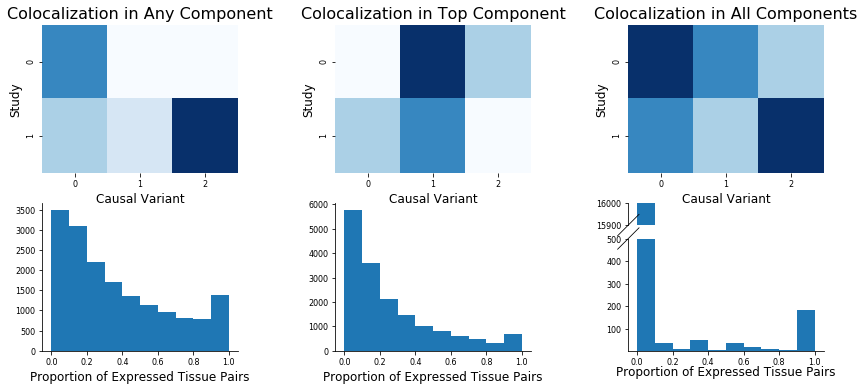

In [63]:
thresh = 0.9

p_coloc_any = np.array([(p.p_coloc > thresh).mean() for p in p_coloc_eqtl])
p_coloc_top = np.array([(p.p_coloc_top > thresh).mean() for p in p_coloc_eqtl])
p_coloc_all = np.array([(p.p_coloc_all > thresh).mean() for p in p_coloc_eqtl])

fig11 = plt.figure(figsize=(14, 6), constrained_layout=False)
gs = fig11.add_gridspec(2,3, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs[0, 0])
sns.heatmap(a, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Any Component')

ax = plt.subplot(gs[0, 1])
sns.heatmap(b, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Top Component')

ax = plt.subplot(gs[0, 2])
sns.heatmap(c, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in All Components')

ax = plt.subplot(gs[1, 0])
ax.hist(p_coloc_any[p_coloc_any >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

ax = plt.subplot(gs[1, 1])
ax.hist(p_coloc_top[p_coloc_top >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')

bax = brokenaxes(ylims=((1, 500), (15900, 16000)), subplot_spec=gs[1, 2])
bax.hist(p_coloc_all[p_coloc_all >= 0])
bax.set_xlabel('Proportion of Expressed Tissue Pairs')
plt.tight_layout()

### Allelic heterogeneity histograms

In [10]:
def generate_coloc_table2(gene):
    m = load_model(gene, decompress=False)
    coloc_table = pd.DataFrame(m.active, index=m.study_ids).reset_index().melt(id_vars='index')
    coloc_table.loc[:, 'gene'] = gene
    coloc_table.rename(columns={'index': 'tissue', 'variable': 'component'}, inplace=True)
    return(coloc_table)

In [ ]:
if not os.path.isfile('component_coloc.pkl'):
    for gene in tqdm(list(gene2path.keys())):
        try:
            d = generte_coloc_table2(gene)
            component_coloc.append(d)
        except Exception as e:
            print(gene)
    pickle.dump(component_coloc, open('component_coloc.pkl', 'wb'))

component_coloc = pickle.load(open('component_coloc.pkl', 'rb'))

In [25]:
components_per_tissue = {}
for d in tqdm(component_coloc):
    try:
        gene = d.iloc[0].gene
        components_per_tissue[gene] = \
            d[d.value > 0.5].groupby('tissue').component.apply(lambda x: np.unique(x).size)
    except Exception as e:
        continue

100%|██████████| 17985/17985 [02:50<00:00, 105.51it/s]


In [26]:
cpt = pd.concat(components_per_tissue)

Text(0.5, 0, 'Components')

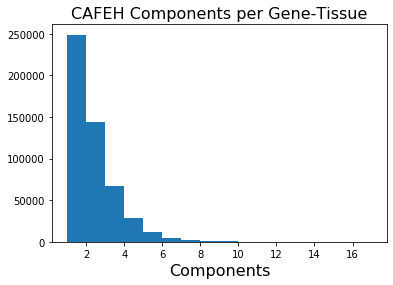

In [37]:
plt.hist(cpt, bins=16)
plt.title('CAFEH Components per Gene, Tissue', size=16)
plt.xlabel('Components', size=16)

In [43]:
components_per_gene = {}
for d in tqdm(component_coloc):
    try:
        gene = d.iloc[0].gene
        components_per_gene[gene] = d[d.value > 0.5].component.unique().size
    except Exception as e:
        continue

100%|██████████| 17985/17985 [00:25<00:00, 697.27it/s]


Text(0.5, 0, 'Components')

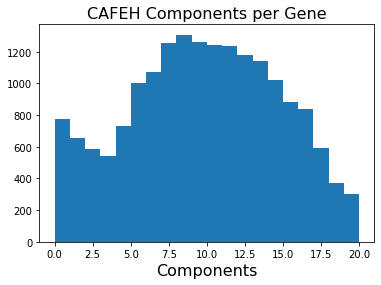

In [45]:
plt.hist(pd.Series(components_per_gene), bins=20)
plt.title('CAFEH Components per Gene', size=16)
plt.xlabel('Components', size=16)

In [18]:
d[d.value > 0.5]

,tissue,component,value,gene


In [102]:
a.prod(0).max()

0.8068094076187897

In [105]:
np.all(result.p_coloc_top < result.p_coloc)

True

In [87]:
result.p_coloc_top < result.p_coloc

1        True
2       False
3        True
4        True
5       False
        ...  
1976     True
1977     True
2022     True
2023     True
2069     True
Length: 1035, dtype: bool

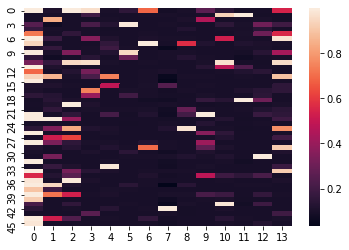

In [61]:
sns.heatmap

In [27]:
m = load_model('ENSG00000187634.11')

In [49]:
compute_p_coloc_any = lambda t1, t2: 1 - \
    np.exp(np.sum(np.log(1e-10 + 1 - active[t1] * active[t2])))

In [50]:
compute_p_coloc_all = lambda t1, t2: 1 - \
    np.exp(np.sum(np.log(active[[t1, t2]])))

In [51]:
#active = active.values
compute_p_coloc_any(0, 1)

0.15840922959892556

In [54]:
active[:2].prod()

4.73643644594873e-42

In [52]:
compute_p_coloc_all(0, 1)

1.0

In [32]:
active = load_active('ENSG00000186092.4')
active

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Kidney_Cortex,0.095451,0.095410,0.095352,0.095302,0.095229,0.095173,0.095114,0.095054,0.094979,0.094917,0.094855,0.094787,0.094724,0.094662,0.094605,0.094544,0.094483,0.094422,0.094362,0.094304
Brain_Putamen_basal_ganglia,0.091249,0.091188,0.091116,0.091045,0.090962,0.090885,0.090807,0.090727,0.090598,0.090515,0.090432,0.090347,0.090263,0.090179,0.090103,0.090020,0.089938,0.089856,0.089775,0.089699
Brain_Substantia_nigra,0.094584,0.094544,0.094489,0.094443,0.094364,0.094313,0.094260,0.094184,0.094117,0.094060,0.094002,0.093932,0.093873,0.093815,0.093757,0.093699,0.093641,0.093583,0.093526,0.093470
Brain_Frontal_Cortex_BA9,0.092690,0.092667,0.092631,0.092610,0.092576,0.092556,0.092536,0.092508,0.092485,0.092465,0.092445,0.092423,0.092403,0.092384,0.092363,0.092343,0.092323,0.092303,0.092282,0.092306
Brain_Hypothalamus,0.093755,0.093714,0.093662,0.093613,0.093553,0.093499,0.093442,0.093384,0.093322,0.093262,0.093202,0.093141,0.093082,0.093022,0.092966,0.092907,0.092849,0.092791,0.092734,0.092680
Brain_Nucleus_accumbens_basal_ganglia,0.095132,0.095083,0.095023,0.094966,0.094903,0.094842,0.094779,0.094715,0.094643,0.094577,0.094510,0.094426,0.094359,0.094292,0.094226,0.094159,0.094094,0.094028,0.093963,0.093898
Brain_Amygdala,0.097248,0.097232,0.097208,0.097188,0.097165,0.097143,0.097120,0.097096,0.097070,0.097047,0.097024,0.096998,0.096976,0.096954,0.096936,0.096915,0.096894,0.096874,0.096855,0.096838
Heart_Left_Ventricle,0.093731,0.093712,0.093692,0.093673,0.093648,0.093629,0.093609,0.093589,0.093570,0.093551,0.093531,0.093506,0.093487,0.093467,0.093481,0.093461,0.093442,0.093422,0.093403,0.093385
Brain_Hippocampus,0.092328,0.092292,0.092248,0.092204,0.092156,0.092109,0.092060,0.092010,0.091952,0.091901,0.091850,0.091797,0.091747,0.091697,0.091665,0.091615,0.091566,0.091518,0.091470,0.091429
Brain_Caudate_basal_ganglia,0.093615,0.093567,0.093513,0.093457,0.093383,0.093322,0.093260,0.093193,0.093128,0.093062,0.092996,0.092919,0.092852,0.092785,0.092717,0.092651,0.092585,0.092519,0.092454,0.092390


In [ ]:
p_coloc_any:

In [ ]:
X = active.iloc[:2].values

In [40]:
np.log(1 - X).sum(0)

array([[0.90454909, 0.90459003, 0.90464762, 0.90469779, 0.90477104,
        0.90482737, 0.90488578, 0.90494564, 0.90502126, 0.90508319,
        0.90514544, 0.90521326, 0.90527568, 0.9053379 , 0.90539471,
        0.90545626, 0.90551736, 0.90557794, 0.90563793, 0.90569637],
       [0.90875059, 0.90881184, 0.90888411, 0.90895523, 0.90903766,
        0.90911453, 0.90919334, 0.90927336, 0.90940152, 0.90948462,
        0.90956808, 0.90965339, 0.90973704, 0.90982055, 0.90989692,
        0.90997978, 0.91006214, 0.91014388, 0.91022488, 0.91030133]])

In [ ]:
{'t1': a, 't2': b, 'p_coloc_any': p_coloc_any, 'p_coloc_all': p_coloc_all, 'p_coloc_top': p_coloc_top}

In [36]:
1 - (1 - 0.001)**20

0.01981113517046529

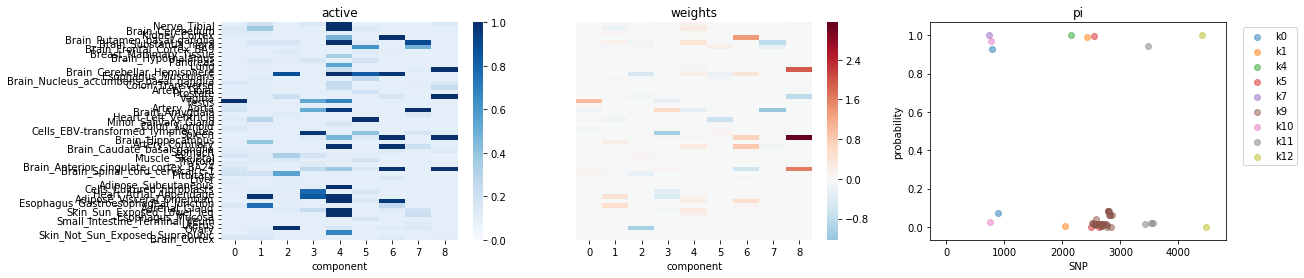

In [28]:
m.plot_components()

In [21]:
model_paths

array(['output/GTEx/chr1/ENSG00000186092.4/ENSG00000186092.4.cafeh_genotype_ss',
       'output/GTEx/chr1/ENSG00000278566.1/ENSG00000278566.1.cafeh_genotype_ss',
       'output/GTEx/chr1/ENSG00000187634.11/ENSG00000187634.11.cafeh_genotype_ss',
       ...,
       'output/GTEx/chr22/ENSG00000251322.7/ENSG00000251322.7.cafeh_genotype_ss',
       'output/GTEx/chr22/ENSG00000100312.10/ENSG00000100312.10.cafeh_genotype_ss',
       'output/GTEx/chr22/ENSG00000079974.17/ENSG00000079974.17.cafeh_genotype_ss'],
      dtype='<U73')

In [8]:
m = load_model(model_paths[0])

In [9]:
m

In [17]:
components_per_tissue = {}
tissues_per_component = {}
total_components = {}
num_tissues = {}
THRESH = 0.99

for gene in tqdm(list(gene2path.keys())[:100]):
    df = load_active(gene2path.get(gene))
    dfna = df.dropna()
    components_per_tissue[gene] = pd.Series((dfna.values > THRESH).sum(1), index=dfna.index)
    tissues_per_component[gene] = pd.Series((dfna.values > THRESH).sum(0))
    total_components[gene] = ((dfna.values > THRESH).sum(0) > 0).sum()
    num_tissues[gene] = dfna.shape[0]

100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Text(0.5, 0, 'Components')

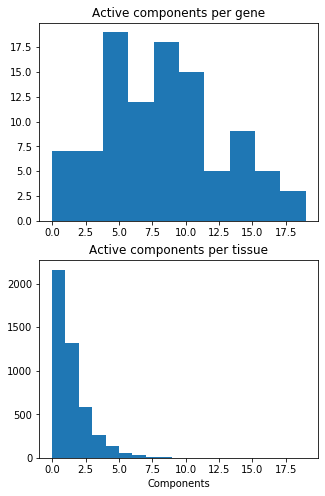

In [18]:
tissues_per_component = pd.DataFrame(tissues_per_component)
components_per_tissue = pd.DataFrame(components_per_tissue)

cpt = components_per_tissue.values.flatten()
fig, ax = plt.subplots(2, 1, figsize=(5, 8))

ax[1].hist(cpt[~np.isnan(cpt)], bins=np.arange(20));
ax[1].set_title('Active components per tissue')

ax[0].hist(total_components.values());
ax[0].set_title('Active components per gene')
ax[1].set_xlabel('Components')